## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [2]:
df = pd.read_csv('../data/processed/encoded_labels/_hot_topics.csv')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', '_hot_topics',
       'Unnamed: 4', 'cov_19', 'crisis_setting', 'digital_transformation',
       'food_and_agricultural_commodities_strategy', 'green_recovery',
       'health', 'human_rights', 'leaving_no_one_behind',
       'multi_stakeholder_collaboration', 'nature_based_solution', 'no tag',
       'plastic', 'poverty_reduction', 'public_private_partnership', 'sids',
       'south_south_cooperation', 'structural_system_transformation'],
      dtype='object')

In [3]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', '_hot_topics'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,Unnamed: 4,34
1,cov_19,8
2,crisis_setting,2
3,digital_transformation,3
4,food_and_agricultural_commodities_strategy,245
5,green_recovery,9
6,health,22
7,human_rights,16
8,leaving_no_one_behind,18
9,multi_stakeholder_collaboration,199


Text(0.5, 0, 'category')

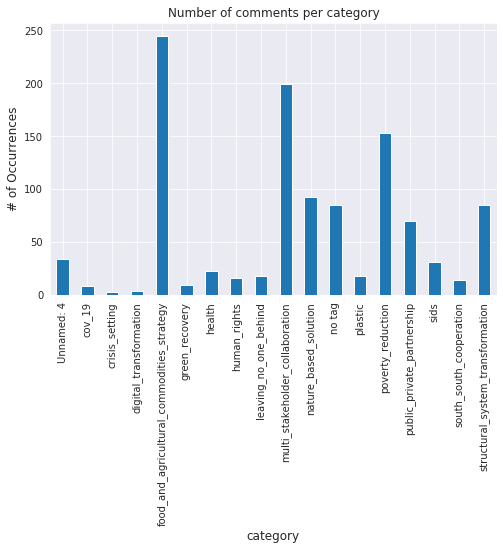

In [4]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

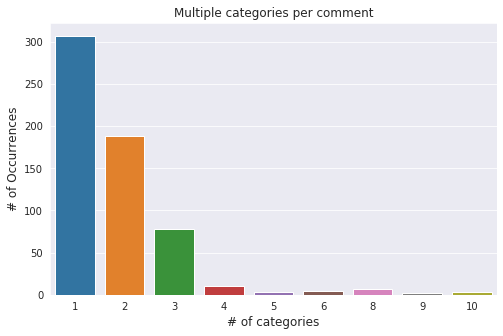

In [5]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## Percentage of inputs that are not labelled

In [6]:
print(len(df[df['no tag']==1]) / len(df))

0.14096185737976782


## The distribution of the number of words in input texts

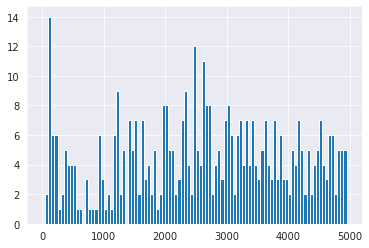

In [7]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [8]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [9]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', '_hot_topics',
       'Unnamed: 4', 'cov_19', 'crisis_setting', 'digital_transformation',
       'food_and_agricultural_commodities_strategy', 'green_recovery',
       'health', 'human_rights', 'leaving_no_one_behind',
       'multi_stakeholder_collaboration', 'nature_based_solution', 'no tag',
       'plastic', 'poverty_reduction', 'public_private_partnership', 'sids',
       'south_south_cooperation', 'structural_system_transformation'],
      dtype='object')

##  Features engineering

In [10]:
categories = ['Unnamed: 4', 'cov_19', 'crisis_setting', 'digital_transformation',
       'food_and_agricultural_commodities_strategy', 'green_recovery',
       'health', 'human_rights', 'leaving_no_one_behind',
       'multi_stakeholder_collaboration', 'nature_based_solution', 'no tag',
       'plastic', 'poverty_reduction', 'public_private_partnership', 'sids',
       'south_south_cooperation', 'structural_system_transformation']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [17]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category                                  </th><th>#Inputs      </th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>Unnamed: 4                                </td><td>34</td><td>AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9388888888888889    
 0.9555555555555556    
 0.9555555555555556    
 0.9555555555555556    
 0.8500000000000000    
 0.8888888888888888                 </td><td>0.646551724137931   
 0.9776536312849162   
 0.9776536312849162   
 0.9776536312849162   
 0.5233026467203682   
 0.47337278106508873                  </td><td>0.5994152046783625    
 0.5555555555555556    
 0.5555555555555556    
 0.5555555555555556    
 0.5526315789473684    
 0.4678362573099415               </td><td>0.6173913043478261    
 0.5885714285714286    
 0.5885714285714286    
 0.5885714285714286    
 0.5234826943818021    
 0.47058823529411764           </td></tr>
<tr><td>cov_19                                    </td><td>8 </td><td>Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333                 </td><td>0.8305084745762712   
 0.8305084745762712   
 0.4916666666666666   
 0.4916666666666666   
 0.4916666666666666   
 0.4916666666666666                  </td><td>0.8305084745762712    
 0.8305084745762712    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000               </td><td>0.8305084745762712    
 0.8305084745762712    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105           </td></tr>
<tr><td>crisis_setting                            </td><td>2</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329           </td></tr>
<tr><td>digital_transformation                    </td><td>3</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9833333333333333                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49719101123595505                  </td><td>0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.49441340782122906               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4957983193277311           </td></tr>
<tr><td>food_and_agricultural_commodities_strategy</td><td>245</td><td>Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree    
 AdaBoost              </td><td>0.7166666666666667    
 0.7055555555555556    
 0.6888888888888889    
 0.6722222222222223    
 0.6666666666666666    
 0.6666666666666666                 </td><td>0.7197786804874632   
 0.7092426187419769   
 0.6852678571428572   
 0.6885714285714286   
 0.660633484162896   
 0.6608297413793103                  </td><td>0.697209653092006    
 0.6843891402714932    
 0.6877828054298643    
 0.6866515837104072    
 0.660633484162896    
 0.6500754147812972               </td><td>0.6995188373539327    
 0.6859259259259259    
 0.6857463524130192    
 0.6721311475409836    
 0.660633484162896    
 0.6511177154671146           </td></tr>
<tr><td>green_recovery                            </td><td>9</td><td>Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9777777777777777    
 0.9722222222222222    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889                 </td><td>0.9972067039106145   
 0.6666666666666666   
 0.5971428571428572   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446                  </td><td>0.7500000000000000    
 0.9887640449438202    
 0.7387640449438202    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000               </td><td>0.8319327731092436    
 0.7443181818181819    
 0.6357749898826387    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456           </td></tr>
<tr><td>health                                    </td><td>22</td><td>K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9777777777777777    
 0.9555555555555556    
 0.9444444444444444    
 0.9555555555555556    
 0.9611111111111111    
 0.9611111111111111                 </td><td>0.8914285714285715   
 0.7027250206440958   
 0.6549707602339181   
 0.6857142857142857   
 0.7331460674157304   
 0.48055555555555557                  </td><td>0.782824112303881    
 0.7027250206440958    
 0.6969446738232865    
 0.634186622625929    
 0.5685383980181667    
 0.5000000000000000               </td><td>0.8275862068965516    
 0.7027250206440958    
 0.6729651162790697    
 0.6551724137931034    
 0.6011396011396012    
 0.49008498583569404           </td></tr>
<tr><td>human_rights                              </td><td>16</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree              </td><td>0.9833333333333333    
 0.9777777777777777    
 0.9777777777777777    
 0.9777777777777777    
 0.9722222222222222    
 0.9611111111111111                 </td><td>0.9915730337078652   
 0.9888268156424581   
 0.9888268156424581   
 0.9888268156424581   
 0.7387640449438202   
 0.6136363636363636                  </td><td>0.7000000000000000    
 0.6000000000000000    
 0.6000000000000000    
 0.6000000000000000    
 0.5971428571428572    
 0.5914285714285714               </td><td>0.7814649939295832    
 0.6610169491525424    
 0.6610169491525424    
 0.6610169491525424    
 0.6357749898826387    
 0.6011396011396012           </td></tr>
<tr><td>leaving_no_one_behind                     </td><td>18</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9722222222222222    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333    
 0.9777777777777777                 </td><td>0.6942857142857143   
 0.9916201117318435   
 0.9916201117318435   
 0.9916201117318435   
 0.9916201117318435   
 0.7415730337078652                  </td><td>0.7414772727272727    
 0.6250000000000000    
 0.6250000000000000    
 0.6250000000000000    
 0.6250000000000000    
 0.6221590909090908               </td><td>0.7150997150997151    
 0.6957746478873239    
 0.6957746478873239    
 0.6957746478873239    
 0.6957746478873239    
 0.6610169491525424           </td></tr>
<tr><td>multi_stakeholder_collaboration           </td><td>199</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest    
 AdaBoost    
 Decsision Tree              </td><td>0.8222222222222222    
 0.8111111111111111    
 0.7944444444444444    
 0.7944444444444444    
 0.7777777777777778    
 0.7111111111111111                 </td><td>0.8236177884615384   
 0.8000000000000000   
 0.7836970474967908   
 0.8091156000679003   
 0.7793640493186242   
 0.6883081896551724                  </td><td>0.7862838915470494    
 0.7870813397129186    
 0.7643540669856459    
 0.7420255183413078    
 0.7288676236044657    
 0.6858054226475279               </td><td>0.798291077181678    
 0.7924297924297925    
 0.7715344242050015    
 0.7565700500749296    
 0.7407834101382489    
 0.6869565217391305           </td></tr>
<tr><td>nature_based_solution                     </td><td>92</td><td>Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 Random Forest              </td><td>0.8277777777777777    
 0.8666666666666667    
 0.7277777777777777    
 0.8444444444444444    
 0.7777777777777778    
 0.8666666666666667                 </td><td>0.6605389358300982   
 0.7314974182444062   
 0.6397993311036789   
 0.6608231707317074   
 0.5733333333333334   
 0.8096590909090908                  </td><td>0.6755744255744256    
 0.6343656343656343    
 0.760989010989011    
 0.6053946053946054    
 0.5824175824175823    
 0.5544455544455544               </td><td>0.6673621460506707    
 0.6625000000000000    
 0.6396911638547327    
 0.6226415094339623    
 0.5770676691729323    
 0.5636363636363636           </td></tr>
<tr><td>no tag                                    </td><td>85</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 AdaBoost    
 Random Forest    
 Decsision Tree              </td><td>0.8833333333333333    
 0.7777777777777778    
 0.8666666666666667    
 0.8277777777777777    
 0.8666666666666667    
 0.7722222222222223                 </td><td>0.9393063583815029   
 0.6377005347593583   
 0.788235294117647   
 0.641465175027066   
 0.9318181818181819   
 0.5814029010608357                  </td><td>0.625000000000000    
 0.6936090225563909    
 0.6151315789473684    
 0.5921052631578947    
 0.5714285714285714    
 0.5883458646616542               </td><td>0.6676923076923077    
 0.6527777777777777    
 0.6469434455704478    
 0.6063492063492064    
 0.5884146341463414    
 0.5844360605889971           </td></tr>
<tr><td>plastic                                   </td><td>18</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Stochastic Gradient Descent              </td><td>0.9722222222222222    
 0.9666666666666667    
 0.9777777777777777    
 0.9777777777777777    
 0.9722222222222222    
 0.9666666666666667                 </td><td>0.7442528735632183   
 0.6914285714285715   
 0.9888268156424581   
 0.9888268156424581   
 0.7387640449438202   
 0.655367231638418                  </td><td>0.7914285714285714    
 0.6914285714285715    
 0.6000000000000000    
 0.6000000000000000    
 0.5971428571428572    
 0.5942857142857143               </td><td>0.7655639489450377    
 0.6914285714285715    
 0.6610169491525424    
 0.6610169491525424    
 0.6357749898826387    
 0.6164772727272727           </td></tr>
<tr><td>poverty_reduction                         </td><td>153</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.7777777777777778    
 0.7888888888888889    
 0.7666666666666667    
 0.7222222222222222    
 0.6833333333333333    
 0.6000000000000000                 </td><td>0.7051671732522796   
 0.7233115468409586   
 0.6806978676266962   
 0.6108374384236454   
 0.5852272727272727   
 0.6262626262626263                  </td><td>0.711111111111111    
 0.6518518518518519    
 0.6074074074074074    
 0.5925925925925926    
 0.5888888888888889    
 0.6666666666666667               </td><td>0.707981829980532    
 0.6701388888888888    
 0.6192586623690572    
 0.5982142857142858    
 0.5868068140630663    
 0.5833333333333335           </td></tr>
<tr><td>public_private_partnership                </td><td>70</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Random Forest              </td><td>0.8611111111111112    
 0.7611111111111111    
 0.8111111111111111    
 0.8666666666666667    
 0.8666666666666667    
 0.8777777777777778                 </td><td>0.5976764199655766   
 0.5255842062852538   
 0.5211141060197664   
 0.5194054500412882   
 0.5194054500412882   
 0.4463276836158192                  </td><td>0.5742072572736188    
 0.5415168355671788    
 0.5230467473030402    
 0.5076822491010134    
 0.5076822491010134    
 0.4906832298136646               </td><td>0.5829858215179317    
 0.5243070493516072    
 0.5218750000000000    
 0.5025333947489636    
 0.5025333947489636    
 0.46745562130177515           </td></tr>
<tr><td>sids                                      </td><td>31</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.9    
 0.9388888888888889    
 0.9611111111111111    
 0.9611111111111111    
 0.9611111111111111    
 0.9611111111111111                 </td><td>0.6300345224395858   
 0.6255161023947151   
 0.9804469273743017   
 0.9804469273743017   
 0.9804469273743017   
 0.9804469273743017                  </td><td>0.8284883720930232    
 0.6104651162790697    
 0.5625000000000000    
 0.5625000000000000    
 0.5625000000000000    
 0.5625000000000000               </td><td>0.6727272727272727    
 0.6173913043478261    
 0.6011396011396011    
 0.6011396011396011    
 0.6011396011396011    
 0.6011396011396011           </td></tr>
<tr><td>south_south_cooperation                   </td><td>14</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9833333333333333    
 0.9444444444444444    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9611111111111111                 </td><td>0.6638418079096046   
 0.5833333333333334   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.4942857142857143                  </td><td>0.7443820224719101    
 0.9719101123595506    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.4859550561797753               </td><td>0.6957746478873239    
 0.6284062758051197    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49008498583569404           </td></tr>
<tr><td>structural_system_transformation          </td><td>85</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest    
 Decsision Tree              </td><td>0.8888888888888888    
 0.8277777777777777    
 0.8111111111111111    
 0.8555555555555555    
 0.9000000000000000    
 0.7777777777777778                 </td><td>0.7108433734939759   
 0.6277332756007794   
 0.6215277777777778   
 0.6234567901234568   
 0.949438202247191   
 0.5464527027027026                  </td><td>0.653125    
 0.6843750000000000    
 0.6968750000000000    
 0.6125000000000000    
 0.5500000000000000    
 0.5687500000000000               </td><td>0.6752075063154096    
 0.6459166190748143    
 0.6405075187969925    
 0.6175220660346519    
 0.5642818719741797    
 0.5504495504495505           </td></tr>
</tbody>
</table>